We will try to determine the classifications of the garbage thrown here

In [ ]:
! gdown https://drive.google.com/file/d/1ZWRlfZV1sQaTr921FKEQC8hNHJyB_kr4/view?usp=sharing

/usr/local/lib/python2.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=1ZWRlfZV1sQaTr921FKEQC8hNHJyB_kr4
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/file/d/1ZWRlfZV1sQaTr921FKEQC8hNHJyB_kr4/view?usp=sharing
To: /content/view?usp=sharing
63.3kB [00:00, 4.17MB/s]


In [ ]:
! gdown https://drive.google.com/uc?id=1ZWRlfZV1sQaTr921FKEQC8hNHJyB_kr4

Downloading...
From: https://drive.google.com/uc?id=1ZWRlfZV1sQaTr921FKEQC8hNHJyB_kr4
To: /content/Garbage Classification.zip
129MB [00:01, 90.3MB/s]


In [ ]:
! unzip Garbage\ Classification.zip

Archive:  Garbage Classification.zip
  inflating: Garbage Classification/~$ro-indexed-files.txt  
 extracting: Garbage Classification/archive.zip  
   creating: Garbage Classification/Garbage classification/
   creating: Garbage Classification/Garbage classification/cardboard/
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard1.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard10.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard100.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard101.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard102.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard103.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard104.jpg  
  inflating: Garbage Classification/Garbage classification/cardboard/cardboard105.jpg  
  inflating: Garbage 

##  Install required libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(0)

In [ ]:
path = "/content/Garbage Classification/Garbage classification"
train_path = path
valid_path = path

In [ ]:
cls = os.listdir(path)
cls

['glass', 'plastic', 'metal', 'cardboard', 'paper', 'trash']

# Data preprocessing

###### - Here, we can reproduce the image by playing with certain features of the visuals we have. The reason for doing this is to get a better result from our model during the future training.

* Deep learning models tend to be good at fitting training data. but the main difficulty is not to make up but to generalize

* avoiding memorizing the model's data

###### - We can take the fillowing steps to prevent overfitting and underfitting

* Dataset Augmentation
* Dropout layer
* Early Stoping

In [ ]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,validation_split=0.1, rotation_range = 20,
                                                      width_shift_range = 0.2,height_shift_range = 0.2,horizontal_flip = True,vertical_flip = True)

In [ ]:
train_idg=idg.flow_from_directory(directory=train_path,target_size=(224,224), classes=cls, batch_size=256, subset='training')
val_idg=idg.flow_from_directory(directory=train_path,target_size=(224,224), classes=cls, batch_size=64, subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


We pulled our data from the library

# Building model

## Pretrained Convolutional Base (VGG16)

> * ##### Pre-Trained Convolutional Base (VGG16) model will be used

In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(weights = 'imagenet',
              include_top = False,
              input_shape = (224,224,3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Fine-tuning

### Freeze VGG layers

> In Keras, each layer has a parameter called "trainable". To freeze the weights of a particular layer, we must set this parameter to False, indicating that this layer should not be trained. So much! We go over each layer and choose which layers we want to train.

In [ ]:
# Freeze the layers except the last 3 layers
for layer in vgg.layers[:-3]:
    layer.trainable = False

## Model definition 

In [ ]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg)
 
# Add new layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 30,416,902
Non-trainable params: 9,995,072
_________________________________________________________________


## Train the model 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

loss='categorical_crossentropy'
* Calculates the crossentropy loss between labels and predictions.
Use this crossentropy loss function when there are two or more tag classes

In [ ]:
# Train the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = tf.keras.callbacks.ModelCheckpoint('VGG16 Garbage_Classification.h5', monitor='val_acc', mode='max', verbose=1,save_best_only=True)

model_history=model.fit(train_idg,epochs=30,validation_data=val_idg,callbacks=[es,mc],verbose=0)
              


Epoch 00001: val_acc improved from -inf to 0.44622, saving model to VGG16 Garbage_Classification.h5

Epoch 00002: val_acc improved from 0.44622 to 0.62151, saving model to VGG16 Garbage_Classification.h5

Epoch 00003: val_acc improved from 0.62151 to 0.70518, saving model to VGG16 Garbage_Classification.h5

Epoch 00004: val_acc did not improve from 0.70518

Epoch 00005: val_acc did not improve from 0.70518

Epoch 00006: val_acc improved from 0.70518 to 0.71315, saving model to VGG16 Garbage_Classification.h5

Epoch 00007: val_acc improved from 0.71315 to 0.73307, saving model to VGG16 Garbage_Classification.h5

Epoch 00008: val_acc improved from 0.73307 to 0.77689, saving model to VGG16 Garbage_Classification.h5

Epoch 00009: val_acc did not improve from 0.77689

Epoch 00010: val_acc did not improve from 0.77689

Epoch 00011: val_acc did not improve from 0.77689

Epoch 00012: val_acc improved from 0.77689 to 0.80876, saving model to VGG16 Garbage_Classification.h5

Epoch 00013: val_ac

In [ ]:
score = model.evaluate(val_idg,batch_size=32,)
score
print('Score Accuracy : {:.2f}%'.format(score[1]*100))

4/4 [==============================] - 4s 819ms/step - loss: 0.5562 - acc: 0.8367
Score Accuracy : 83.67%


### Training history

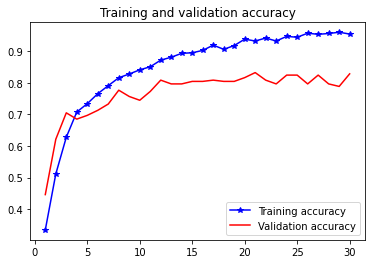

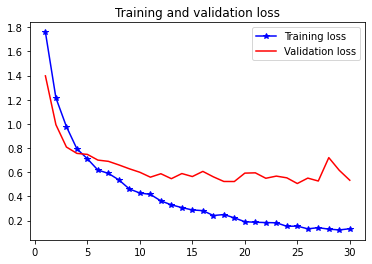

In [ ]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

BThis is visible if you plot validation metrics and compare them to training metrics.

* It is normal to have a little difference.
* If both measurements move in the same direction, everything is fine.
* If the validation metric starts to stagnate as the training metric continues to improve, you are probably approaching overfitting.
* If the validation metric starts to stagnate as the training metric continues to improve, you are probably approaching overfitting.

# Prediction on test set

## Test set accuracy

In [ ]:
pred_Y = model.predict(val_idg, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)

4/4 [==============================] - 4s 888ms/step


In [ ]:
cls = os.listdir(path)
cls

['glass', 'plastic', 'metal', 'cardboard', 'paper', 'trash']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
LABELS=["CARDBOARD","GLASS","METAL","PAPER","PLASTIC","TRASH"]
# binarize the labels
labels = np.array(LABELS)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
!pip install imutils

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [ ]:
print("[INFO] loading object detector...")
model = load_model("/content/VGG16 Garbage_Classification.h5")

[INFO] loading object detector...


In [ ]:
def predict(imagePath):
    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    # make bounding box predictions on the input image
    proba = model.predict(image)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    label = "{}: {:.2f}% ".format(label, proba[idx] * 100)
    cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
        0.7, (255, 0, 0), 2)
        
    # show the output image
    fig=plt.figure(figsize=(10,10))
    plt.grid(b=None)
    plt.axis('off')
    return plt.imshow(output)

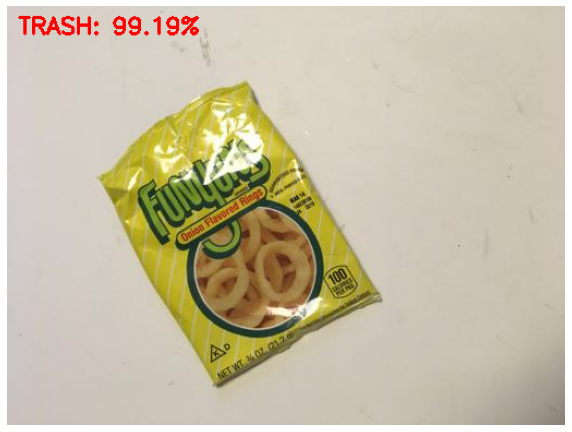

In [ ]:
imagePath = "/content/Garbage Classification/Garbage classification/trash/trash109.jpg"
predict(imagePath)

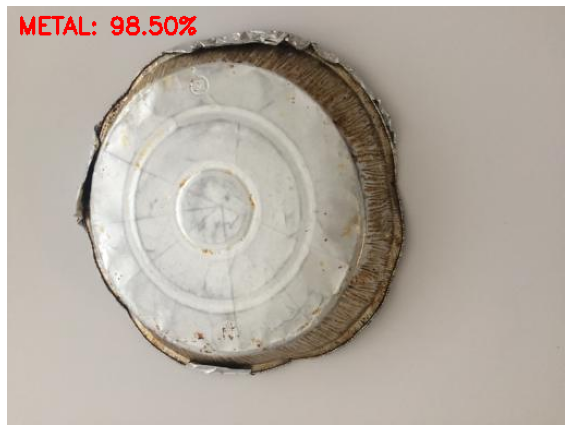

In [ ]:
imagePath = "/content/Garbage Classification/Garbage classification/metal/metal170.jpg"
predict(imagePath)